In [93]:
import pandas as pd



train = pd.read_csv("data/train.csv")
test= pd.read_csv("data/test.csv")


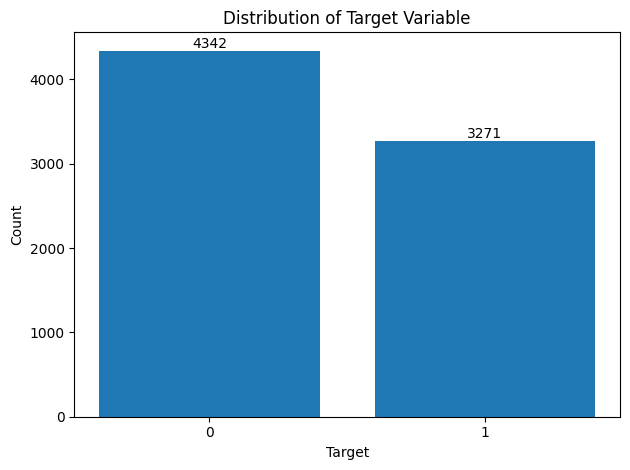

In [94]:
import matplotlib.pyplot as plt


# Count the 0s and 1s
counts = train['target'].value_counts().sort_index()

# Make the plot
fig, ax = plt.subplots()
bars = ax.bar(['0', '1'], counts.values)

# Add count labels above the bars
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            str(int(bar.get_height())),
            ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Target Variable")
plt.xlabel("Target")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

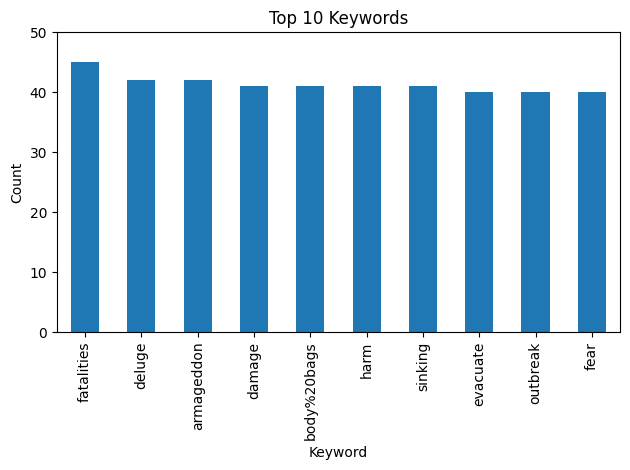

In [95]:
import matplotlib.pyplot as plt

top10 = train['keyword'].value_counts().head(10)
top10.plot(kind='bar')
plt.title("Top 10 Keywords")
plt.ylim(0, 50)
plt.xlabel("Keyword")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
from urllib.parse import unquote 

mask = train['keyword'].str.contains('%', na=False)
train.loc[mask, 'keyword'] = train.loc[mask, 'keyword'].apply(unquote)

In [ ]:
import pandas as pd
from pathlib import Path

missing_mask = train['keyword'].isna() | train['keyword'].str.strip().eq('')
print(f"Missing keywords: {missing_mask.sum()} / {len(train)}")

Missing keywords: 61 / 7613


In [ ]:
import re, warnings, numpy as np, pandas as pd
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

#flag rows that already have a keyword vs. blanks
mask_missing = train['keyword'].isna() | train['keyword'].str.strip().eq('')
mask_known   = ~mask_missing

X_train = train.loc[mask_known, 'text']
y_train = train.loc[mask_known, 'keyword']

#Encode string labels to integers 
le   = LabelEncoder()
y_enc = le.fit_transform(y_train)

#text feature extractors
#capture full words)
#catch hashtags, typos, 
word_vect = TfidfVectorizer(lowercase=True, stop_words='english',
                            ngram_range=(1, 2), max_features=25_000,
                            dtype=np.float32)

char_vect = TfidfVectorizer(analyzer='char', ngram_range=(3, 5),
                            min_df=3, max_features=40_000,
                            dtype=np.float32)

# combine
feats = FeatureUnion([('word', word_vect), ('char', char_vect)])

#classifier -  (SGD logistic regression on sparse data)
sgd = SGDClassifier(loss='log_loss',             # logistic-reg loss
                    penalty='l2',
                    class_weight='balanced',     
                    max_iter=5_000,
                    n_jobs=-1,
                    random_state=42)

pipe = Pipeline([('feats', feats), ('clf', sgd)])

# grid-search over alpha 
param_grid = {'clf__alpha': [0.0001, 0.00005, 0.00001]}  # decimal form
with warnings.catch_warnings():
    warnings.simplefilter('ignore')          
    gs = GridSearchCV(pipe, param_grid,
                      cv=3, scoring='accuracy',
                      n_jobs=-1, verbose=0)
    gs.fit(X_train, y_enc)

pipe_best = gs.best_estimator_
print(f"SGD best CV accuracy: {gs.best_score_:.3f}")

#predict on the blank rows, keep confident matches
X_blank = train.loc[mask_missing, 'text'].fillna("")
proba   = pipe_best.predict_proba(X_blank.tolist())
pred_id = proba.argmax(1)
pred_kw = le.inverse_transform(pred_id)
conf    = proba.max(1)

THRESH = 0.10                              # prob
good_rows, good_kw = [], []

for i, (kw, p) in enumerate(zip(pred_kw, conf)):
    if p < THRESH:
        continue                           # skip low-confidence
    txt = str(X_blank.iloc[i]).lower()
    if kw in txt or kw.replace(' ', '') in txt:
        good_rows.append(i)
        good_kw.append(kw)

# write back accepted model labels
indices = mask_missing[mask_missing].index[good_rows]
train.loc[indices, 'keyword'] = good_kw
print(f"Model filled {len(indices)} of {mask_missing.sum()} blanks.")

# 5 ▸ heuristic fallback (hashtags + small disaster vocab)
still_blank = train['keyword'].isna() | train['keyword'].str.strip().eq('')
if still_blank.any():
    TAG_RE = re.compile(r'#([A-Za-z0-9_]+)')
    VOCAB  = {
        'earthquake','flood','fire','wildfire','hurricane','tornado',
        'storm','explosion','evacuation','drought','heatwave','cyclone',
        'eruption','volcano','tsunami','landslide','collision','damage',
        'thunderstorm','hail','blizzard','quarantine','smoke','sirens',
        'aftershock','mudslide','ice','lightning','burst','collapse'
    }

    def heuristic(text: str):
        t = text.lower()
        # 1) prefer hashtags
        tags = TAG_RE.findall(t)
        if tags:
            return tags[0]
        # 2) else first vocab word present
        for w in re.findall(r'[a-z]+', t):
            if w in VOCAB:
                return w
        return np.nan

    filled_h = train.loc[still_blank, 'text'].apply(heuristic)
    n_h      = filled_h.notna().sum()
    train.loc[still_blank, 'keyword'] = filled_h
    print(f"Heuristic filled {n_h} additional blanks.")

# final tally
total_filled = (mask_missing & train['keyword'].notna()).sum()
print(f"\nTotal blanks filled: {total_filled} / {mask_missing.sum()} "
      f"({total_filled/mask_missing.sum():.1%})")

SGD best CV accuracy: 0.915
Model filled 33 of 61 blanks.
Heuristic filled 12 additional blanks.

Total blanks filled: 45 / 61 (73.8%)


In [100]:
#remove rows with empty keywords after
train = train[train['keyword'].notna() & train['keyword'].str.strip().ne('')].copy()

In [99]:
miss = train['location'].isna() | train['location'].str.strip().eq('')
print(f"Missing locations: {miss.mean():.1%}  ({miss.sum()} / {len(train)})")

Missing locations: 33.3%  (2534 / 7613)
